<a href="https://colab.research.google.com/github/Hadiss-bni/DeepLreaning-UtechAcademy/blob/master/Homework_series1_N5_LRfinderCallback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/Alireza-Akhavan/SRU-deeplearning-workshop/master/dataset.py
!mkdir dataset
!wget https://github.com/Alireza-Akhavan/SRU-deeplearning-workshop/raw/master/dataset/Data_hoda_full.mat -P dataset

--2020-09-18 18:44:59--  https://raw.githubusercontent.com/Alireza-Akhavan/SRU-deeplearning-workshop/master/dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 929 [text/plain]
Saving to: ‘dataset.py.4’

dataset.py.4        100%[===================>]     929  --.-KB/s    in 0s      

2020-09-18 18:45:00 (68.1 MB/s) - ‘dataset.py.4’ saved [929/929]

mkdir: cannot create directory ‘dataset’: File exists
--2020-09-18 18:45:00--  https://github.com/Alireza-Akhavan/SRU-deeplearning-workshop/raw/master/dataset/Data_hoda_full.mat
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Alireza-Akhavan/SRU-dee

In [ ]:
# 1. Import libraries and modules
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import numpy as np
from dataset import load_hoda
import matplotlib.pyplot as plt

np.random.seed(123)  # for reproducibility

# Load pre-shuffled HODA data into train and test sets
x_train_original, y_train_original, x_test_original, y_test_original = load_hoda(
                                                                        training_sample_size=3500,
                                                                        test_sample_size=400,size=28)

# Preprocess input data
''' 3.1: input data in numpy array format'''
x_train = np.array(x_train_original)
x_test = np.array(x_test_original)
'''3.2 normalize our data values to the range [0, 1]'''
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Reshape to original image shape (n x 784)  ==> (n x 28 x 28 x 1)
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)


# 4. Preprocess class labels
y_train = keras.utils.to_categorical(y_train_original, num_classes=10)
y_test = keras.utils.to_categorical(y_test_original, num_classes=10)


# test and validation set
x_val = x_test[:200]
x_test = x_test[200:]
y_val = y_test[:200]
y_test = y_test[200:]

# 5. Define model architecture
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))


# 6. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




In [ ]:
from keras.callbacks import Callback

class LRFinder(Callback):
    """
    Up-to date version: https://github.com/WittmannF/LRFinder
    Example of usage:
        from keras.models import Sequential
        from keras.layers import Flatten, Dense
        from keras.datasets import fashion_mnist
        !git clone https://github.com/WittmannF/LRFinder.git
        from LRFinder.keras_callback import LRFinder
        # 1. Input Data
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        mean, std = X_train.mean(), X_train.std()
        X_train, X_test = (X_train-mean)/std, (X_test-mean)/std
        # 2. Define and Compile Model
        model = Sequential([Flatten(),
                            Dense(512, activation='relu'),
                            Dense(10, activation='softmax')])
        model.compile(loss='sparse_categorical_crossentropy', \
                      metrics=['accuracy'], optimizer='sgd')
        # 3. Fit using Callback
        lr_finder = LRFinder(min_lr=1e-4, max_lr=1)
        model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder], epochs=2)
    """
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

Epoch 1/200
14/14 [==============================] - 0s 8ms/step - loss: 2.3034 - accuracy: 0.1137 - val_loss: 2.2947 - val_accuracy: 0.1600
Epoch 2/200
14/14 [==============================] - 0s 7ms/step - loss: 2.3018 - accuracy: 0.1120 - val_loss: 2.2947 - val_accuracy: 0.1600
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 2.3020 - accuracy: 0.1163 - val_loss: 2.2947 - val_accuracy: 0.1600
Epoch 4/200
14/14 [==============================] - 0s 7ms/step - loss: 2.2996 - accuracy: 0.1154 - val_loss: 2.2947 - val_accuracy: 0.1600
Epoch 5/200
14/14 [==============================] - 0s 7ms/step - loss: 2.3019 - accuracy: 0.1177 - val_loss: 2.2947 - val_accuracy: 0.1600
Epoch 6/200
14/14 [==============================] - 0s 7ms/step - loss: 2.3001 - accuracy: 0.1197 - val_loss: 2.2947 - val_accuracy: 0.1600
Epoch 7/200
14/14 [==============================] - 0s 9ms/step - loss: 2.3030 - accuracy: 0.1186 - val_loss: 2.2947 - val_accuracy: 0.1600
Epoch 8/200
1

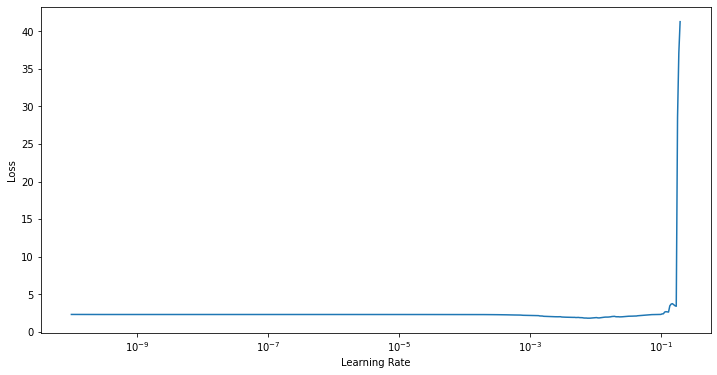

In [ ]:
# 7. Fit model on training data
callback = LRFinder(min_lr=1e-10,max_lr=1e+1)
history = model.fit(x_train, y_train, epochs=200,batch_size=265,
           validation_data = (x_val, y_val),callbacks=[callback])